# Baseline Transformer

In [77]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Lambda
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [78]:
file_name = ".SEED.txt"
with open(file_name, "r") as file:
    content = file.read().strip()  # Read and remove any extra whitespace/newlines
    number = int(content)  # Use float() to support decimal; use int() if it's always an integer

print("Seed:", number)
print("Type:", type(number))

Seed: 271828183
Type: <class 'int'>


In [79]:
CSV_PATH   = "ALL_MERGED.csv"  # <--- set your CSV path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # set False to exclude JKSE from X
CHECKPOINT_PATH = "Model Checkpoints/transformer_baseline_checkpoint.keras"

LOOKBACK   = 20
TEST_SIZE  = 0.20
VAL_SIZE   = 0.10

RANDOM_SEED = number
EPOCHS      = 100
BATCH_SIZE  = 32

# Transformer hyperparams (baseline)
D_MODEL       = 64     # embedding size
NUM_HEADS     = 4
DFF           = 128    # feed-forward hidden size
DROPOUT_RATE  = 0.2
NUM_LAYERS    = 2      # number of encoder blocks

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

271828183


In [80]:
df = pd.read_csv(CSV_PATH)

required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,232.0790,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-02,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,234.9300,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-03,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,240.3580,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-04,13750.0000,62.2000,2136,12980.0000,2090.5100,14467.5000,239.0180,6986.0000,28123.8203,19531.6309,2114.4900,18070.4004,4480.4639,5140.9370
2015-05-05,14245.0000,62.5000,2136,13047.5000,2102.3900,14594.9000,236.1210,6927.6001,27755.5391,19531.6309,2089.4600,17928.1992,4298.7061,5160.1074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.8800,93.7500,4057,16830.0000,2309.3700,19127.3000,93754.8438,8415.2998,21980.7402,35705.7383,5525.2100,40113.5000,3295.0601,6678.9150
2025-04-28,15637.6300,95.6000,3943,16855.0000,2310.5900,19251.8000,94978.7500,8417.2998,21971.9609,35839.9883,5528.7500,40227.5898,3288.4150,6722.9658
2025-04-29,15564.0000,97.2500,3911,16760.0000,2305.5200,19082.1000,94284.7891,8463.5000,22008.1094,35839.9883,5560.8301,40527.6211,3286.6550,6749.0752


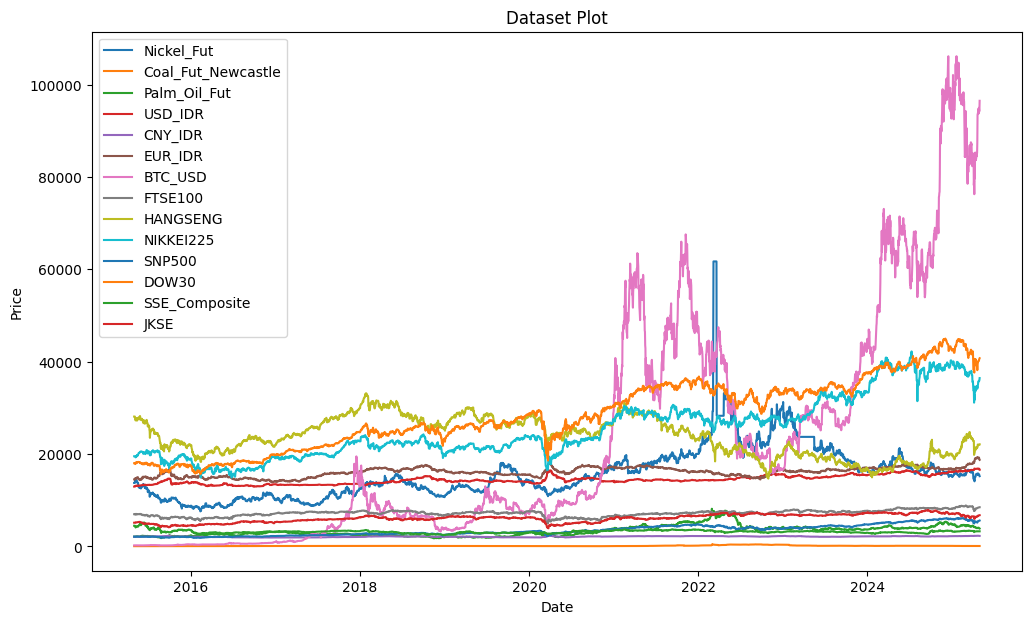

In [81]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [82]:
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | "
      f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | "
      f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [83]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()          # includes TARGET_COL (JKSE)
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]

In [84]:
# feature_cols = [c for c in df.columns if c != TARGET_COL]
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [85]:
def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index

    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])
        idx_list.append(idx[i])

    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

X_train, y_train, idx_train = make_windows(X_train_s, y_train_s, LOOKBACK)
X_val,   y_val,   idx_val   = make_windows(X_val_s,   y_val_s,   LOOKBACK)
X_test,  y_test,  idx_test  = make_windows(X_test_s,  y_test_s,  LOOKBACK)

In [86]:
def positional_encoding(length, depth):
    # depth must be even
    depth = depth if depth % 2 == 0 else depth + 1
    positions = np.arange(length)[:, np.newaxis]       # (length, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth   # (1, depth)
    angle_rates = 1.0 / (10000 ** (2 * (depths // 2) / depth))
    angle_rads = positions * angle_rates
    # apply sin to even indices; cos to odd indices
    pos_encoding = np.zeros((length, depth))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(pos_encoding, tf.float32)  # (length, depth)

POS_ENC = positional_encoding(LOOKBACK, D_MODEL)  # cached tensor

class AddPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.pos = POS_ENC  # (LOOKBACK, D_MODEL)

    def call(self, x):
        # x: (batch, lookback, d_model)
        return x + self.pos

In [87]:
def transformer_encoder(x, num_heads, d_model, dff, dropout_rate):
    # Multi-head self-attention (causal to preserve order)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        x, x, use_causal_mask=True
    )
    x = Add()([x, Dropout(dropout_rate)(attn_output)])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward
    ff = Dense(dff, activation="relu")(x)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(d_model)(ff)

    x = Add()([x, Dropout(dropout_rate)(ff)])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

In [88]:
inp = Input(shape=(LOOKBACK, len(feature_cols)))
# Project features to model dimension
x = Dense(D_MODEL)(inp)
x = AddPositionalEncoding()(x)

for _ in range(NUM_LAYERS):
    x = transformer_encoder(x, NUM_HEADS, D_MODEL, DFF, DROPOUT_RATE)

# Take last time step representation
x = Lambda(lambda t: t[:, -1, :])(x)
out = Dense(1)(x)

model = Model(inputs=inp, outputs=out)
model.compile(optimizer="adam", loss="mse")
model.summary(line_length=110, expand_nested=True, show_trainable=True)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=CHECKPOINT_PATH,
                    monitor="val_loss",
                    save_best_only=True)
]

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape            ┃         Param # ┃ Connected to           ┃ Trainab… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ input_layer_4 (InputLayer) │ (None, 20, 14)          │               0 │ -                      │    -     │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ dense_24 (Dense)           │ (None, 20, 64)          │             960 │ input_layer_4[0][0]    │    Y     │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ add_positional_encoding_4  │ (None, 20, 64)          │               0 │ dense_24[0][0]         │    -     │
│ (AddPositionalEncoding)    │                         │                 │                        │          │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ multi_head_attention_8     │ (None, 20, 64)          │          16,640 │ add_positional_encodi… │    Y     │
│ (MultiHeadAttention)       │                         │                 │ add_positional_encodi… │          │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ dropout_33 (Dropout)       │ (None, 20, 64)          │               0 │ multi_head_attention_… │    -     │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ add_16 (Add)               │ (None, 20, 64)          │               0 │ add_positional_encodi… │    -     │
│                            │                         │                 │ dropout_33[0][0]       │          │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ layer_normalization_16     │ (None, 20, 64)          │             128 │ add_16[0][0]           │    Y     │
│ (LayerNormalization)       │                         │                 │                        │          │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ dense_25 (Dense)           │ (None, 20, 128)         │           8,320 │ layer_normalization_1… │    Y     │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ dropout_34 (Dropout)       │ (None, 20, 128)         │               0 │ dense_25[0][0]         │    -     │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ dense_26 (Dense)           │ (None, 20, 64)          │           8,256 │ dropout_34[0][0]       │    Y     │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ dropout_35 (Dropout)       │ (None, 20, 64)          │               0 │ dense_26[0][0]         │    -     │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ add_17 (Add)               │ (None, 20, 64)          │               0 │ layer_normalization_1… │    -     │
│                            │                         │                 │ dropout_35[0][0]       │          │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ layer_normalization_17     │ (None, 20, 64)          │             128 │ add_17[0][0]           │    Y     │
│ (LayerNormalization)       │                         │                 │                        │          │
├────────────────────────────┼─────────────────────────┼─────────────────┼────────────────────────┼──────────┤
│ multi_head_attention_9     │ (None, 20, 64)          │          16,640 │ layer_normalization_1… │    Y     │
│ (M

 Total params: 67,969 (265.50 KB)

 Trainable params: 67,969 (265.50 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
start_train = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
end_train = time.time()
print(f"\nTraining time: {end_train - start_train:.4f} seconds")

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.8023 - val_loss: 0.1013
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1416 - val_loss: 0.0197
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0985 - val_loss: 0.0189
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0732 - val_loss: 0.0125
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0610 - val_loss: 0.0173
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0476 - val_loss: 0.0257
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0434 - val_loss: 0.0212
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0400 - val_loss: 0.0334
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0347 - val_loss: 0.0154
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0364 - val_loss: 0.0118
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0290 - val_loss: 0.0084
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

In [90]:
def predict_block(X_block, idx_block, verbose=1):
    yhat_s = model.predict(X_block, verbose=verbose)
    yhat = y_scaler.inverse_transform(yhat_s).squeeze()
    return pd.Series(yhat, index=idx_block, name="Pred")

pred_train = predict_block(X_train, idx_train)
pred_val   = predict_block(X_val,   idx_val)

start_test = time.time()
pred_test  = predict_block(X_test,  idx_test, verbose=0)
end_test = time.time()
print(f"Testing (inference) time: {end_test - start_test:.4f} seconds")

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing (inference) time: 0.1555 seconds


In [91]:
actual       = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

In [92]:
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

metrics_train = compute_metrics(actual_train.values, pred_train.values)
metrics_val   = compute_metrics(actual_val.values,   pred_val.values)
metrics_test  = compute_metrics(actual_test.values,  pred_test.values)

metrics_df = pd.DataFrame(
    [metrics_train, metrics_val, metrics_test],
    columns=["MSE", "MAE", "RMSE", "MAPE", "R²"],
    index=["Train", "Validation", "Test"]
)

pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics Summary (Transformer) ===")
print(metrics_df.round(4))


=== Metrics Summary (Transformer) ===
                   MSE      MAE     RMSE   MAPE      R²
Train        3875.9873  47.9451  62.2574 0.0084  0.9923
Validation   2695.2488  41.2134  51.9158 0.0059  0.9009
Test       137104.5833 312.2094 370.2764 0.0431 -0.2102


In [93]:
residuals = pd.Series(actual_test.values - pred_test.values, index=actual_test.index, name="Residuals")

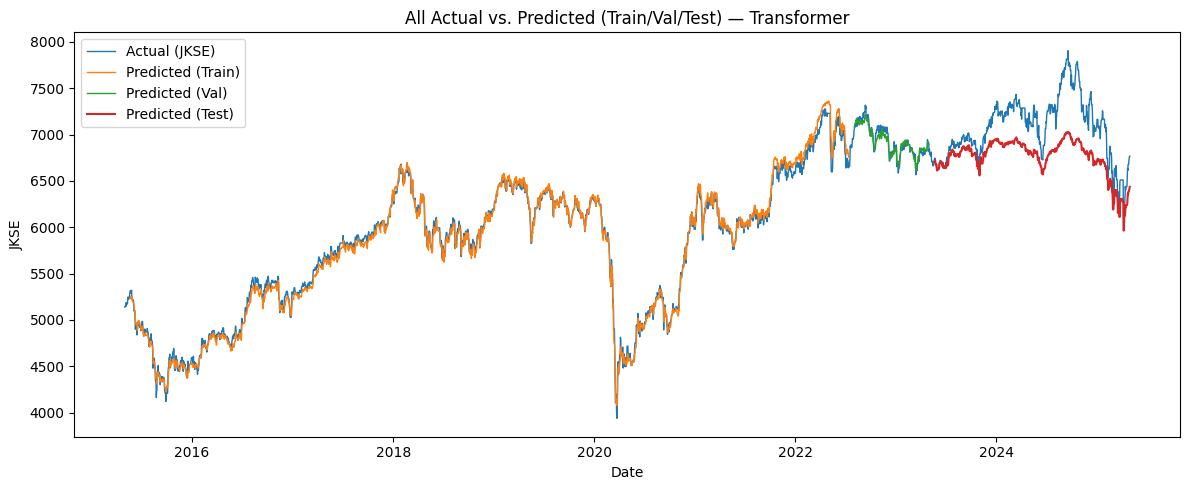

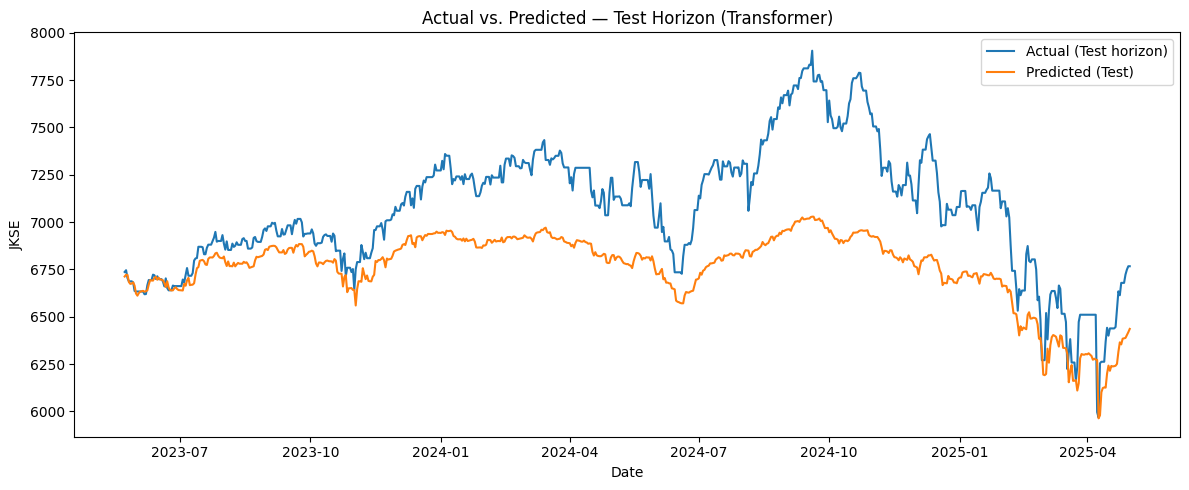

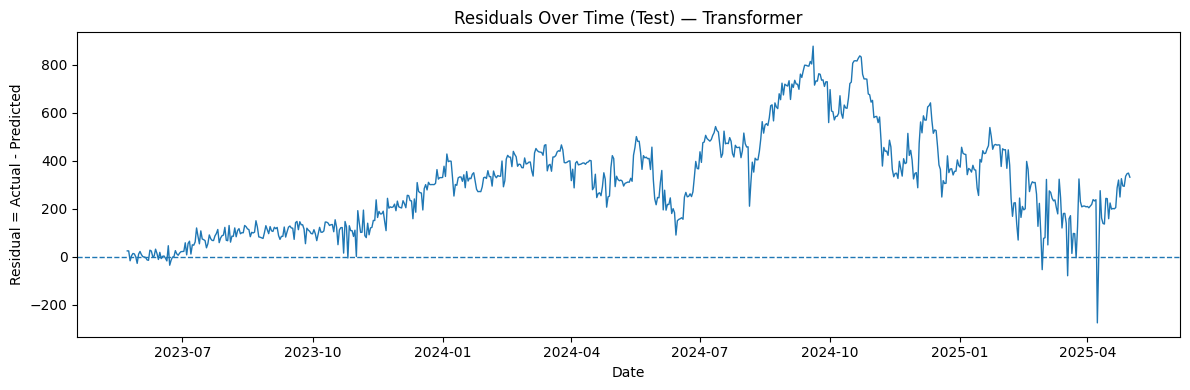

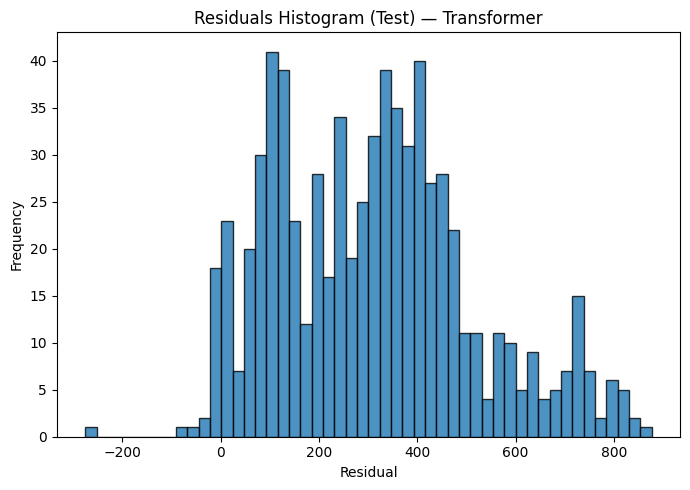

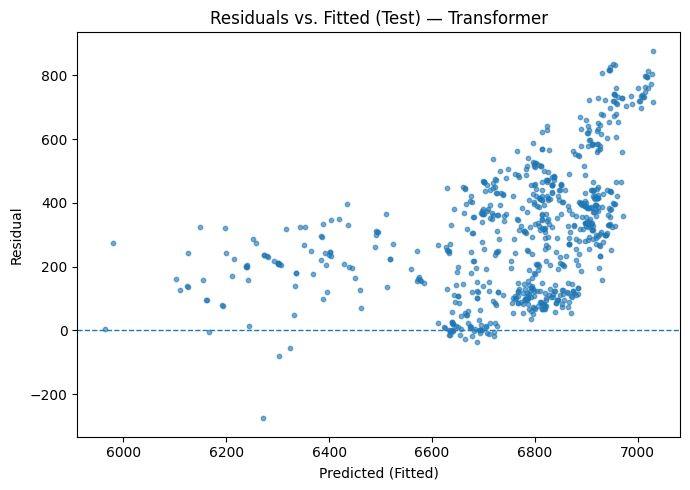

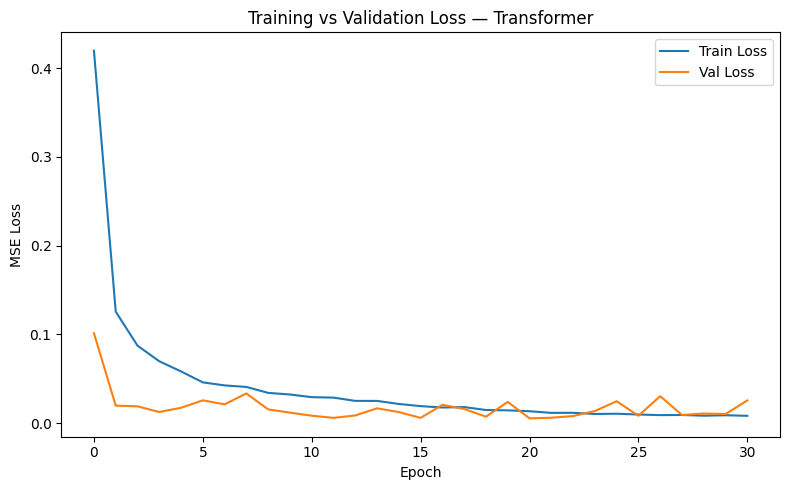

In [94]:
# 1) All actual vs predicted (train/val/test)
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual.values, label="Actual (JKSE)", linewidth=1)
plt.plot(pred_train.index, pred_train.values, label="Predicted (Train)", linewidth=1)
plt.plot(pred_val.index,   pred_val.values,   label="Predicted (Val)", linewidth=1)
plt.plot(pred_test.index,  pred_test.values,  label="Predicted (Test)", linewidth=1.5)
plt.title("All Actual vs. Predicted (Train/Val/Test) — Transformer")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Actual vs predicted on the prediction (test) timeline only
plt.figure(figsize=(12, 5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test horizon)", linewidth=1.5)
plt.plot(pred_test.index,   pred_test.values,   label="Predicted (Test)", linewidth=1.5)
plt.title("Actual vs. Predicted — Test Horizon (Transformer)")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Residuals over time
plt.figure(figsize=(12, 4))
plt.plot(residuals.index, residuals.values, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals Over Time (Test) — Transformer")
plt.xlabel("Date"); plt.ylabel("Residual = Actual - Predicted")
plt.tight_layout()
plt.show()

# 4) Residual histogram
plt.figure(figsize=(7, 5))
plt.hist(residuals.values, bins=50, edgecolor="black", alpha=0.8)
plt.title("Residuals Histogram (Test) — Transformer")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 5) Residual scatter (residuals vs fitted)
plt.figure(figsize=(7, 5))
plt.scatter(pred_test.values, residuals.values, s=10, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals vs. Fitted (Test) — Transformer")
plt.xlabel("Predicted (Fitted)"); plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# 6) Train vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss — Transformer")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
# === CONFIGURATION ===
results_dir = os.path.join("..", "Results")
predicted_path = os.path.join(results_dir, "ALL_PREDICTED.csv")
metrics_path = os.path.join(results_dir, "ALL_METRICS.csv")

# Manual model name (since __file__ isn't available in notebooks)
model = "transformer_baseline"
model_name = f"{model}_{RANDOM_SEED}"   # change this for each notebook (e.g., GRU_Baseline)
print("Model Name for Documentation:", model_name)

# Create Results directory if not exists
os.makedirs(results_dir, exist_ok=True)

# ==========================================
# 1️⃣ PREPARE AND ALIGN TESTING DATAFRAME
# ==========================================

# Convert dates
test_dates = test_df.index.to_series().reset_index(drop=True)
actual_values = test_df[TARGET_COL].values

# If ALL_PREDICTED doesn't exist, create the base file
if not os.path.exists(predicted_path):
    print("Creating ALL_PREDICTED.csv ...")
    base_df = pd.DataFrame({
        "date": test_dates,
        "actual": actual_values
    })
    base_df.to_csv(predicted_path, index=False)

# Load and ensure datetime consistency
all_pred_df = pd.read_csv(predicted_path)
all_pred_df["date"] = pd.to_datetime(all_pred_df["date"])

# Ensure the file covers full test range (in case it was made from smaller data)
base_df = pd.DataFrame({
    "date": test_dates,
    "actual": actual_values
})
# Outer merge to make sure we have the full timeline
all_pred_df = pd.merge(base_df, all_pred_df, on=["date", "actual"], how="outer")

# Create new prediction column (aligned to date)
pred_series = pd.Series(pred_test, index=pd.to_datetime(idx_test), name=model_name)
pred_series = pred_series.reindex(all_pred_df["date"])  # align by date

# Add or update the model column
all_pred_df[model_name] = pred_series.values

# Sort and save
all_pred_df = all_pred_df.sort_values("date").reset_index(drop=True)
all_pred_df.to_csv(predicted_path, index=False)
print(f"✅ Predictions saved to {predicted_path}")

# ==========================================
# 2️⃣ RECORD METRICS SUMMARY
# ==========================================
metrics_columns = [
    "timestamp",
    "model_name", 
    "seed",
    "mse",
    "mae",
    "rmse", 
    "mape",
    "r2_score",
    "picp",
    "mpiw",
    "winkler_score",
    "training_time_s",
    "testing_time_s", 
    "hpo_trial_s",
    "hpo_time_s"
]

# Create ALL_METRICS if missing
if not os.path.exists(metrics_path):
    print("Creating ALL_METRICS.csv ...")
    pd.DataFrame(columns=metrics_columns).to_csv(metrics_path, index=False)

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Extract metrics
mse, mae, rmse, mape, r2 = metrics_test
picp = mpiw = winkler = hpo_trial_s = hpo_time_s = 0

# Build metrics row
metrics_row = {
    "timestamp": timestamp,
    "model_name": model_name,
    "seed": RANDOM_SEED,
    "mse": mse,
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2_score": r2,
    "picp": picp,
    "mpiw": mpiw,
    "winkler_score": winkler,
    "training_time_s": round(end_train - start_train, 4),
    "testing_time_s": round(end_test - start_test, 4),
    "hpo_trial_s": hpo_trial_s,
    "hpo_time_s": hpo_time_s
}

# Append metrics
all_metrics_df = pd.read_csv(metrics_path)
all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)
all_metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics appended to {metrics_path}")

print("\n📄 Documentation of predictions and metrics completed successfully.")


Model Name for Documentation: transformer_baseline_271828183
✅ Predictions saved to ..\Results\ALL_PREDICTED.csv
✅ Metrics appended to ..\Results\ALL_METRICS.csv

📄 Documentation of predictions and metrics completed successfully.
